# Transition period for EIP 1559

###### October 2020

---

In this notebook we model and simulate the transition period suggestested in [Pull Request 2924](https://github.com/ethereum/EIPs/pull/2924). To simulate the transition period we will use a few classes from our [`abm1559`](https://github.com/barnabemonnot/abm1559) library, as well as the Strategic User presented in the [previous notebook](https://github.com/barnabemonnot/abm1559/blob/master/notebooks/stationary1559.ipynb).

In [1]:
import os, sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
# You may remove the two lines above if you have installed abm1559 from pypi

from typing import Sequence, Dict

from abm1559.utils import (
    constants,
    basefee_from_csv_history,
    get_basefee_bounds,
    flatten
)

from abm1559.txpool import TxPool

from abm1559.users import (
    User1559,
    AffineUser,
    User
)

from abm1559.txs import Transaction, Tx1559, TxLegacy

from abm1559.userpool import UserPool

from abm1559.chain import (
    Chain,
    Block1559,
    Block
)

from abm1559.simulator import (
    spawn_poisson_heterogeneous_demand,
    update_basefee,
)

import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
class OptimisticUser(User1559):
    def __init__(self, wakeup_block, **kwargs):
        super().__init__(wakeup_block, cost_per_unit = 0, **kwargs)

class StrategicUser(User1559):
    """
    A strategic affine user sending 1559 transactions.

    - Expects to be included in the next block
    - Prefers not to participate if its expected payoff is negative
    - Strategic gas_premium
    """

    epsilon = 0.1 # how much the user overbids by

    def __init__(self, wakeup_block, **kwargs):
        super().__init__(wakeup_block, cost_per_unit = 0, **kwargs)

    def decide_parameters(self, env):
        if env["min_premium"] is None:
            min_premium = 1 * (10 ** 9)
        else:
            min_premium = env["min_premium"]

        gas_premium = min_premium + self.epsilon * (10 ** 9)
        max_fee = self.value

        return {
            "max_fee": max_fee, # in wei
            "gas_premium": gas_premium, # in wei
            "start_block": self.wakeup_block
        }

    def export(self):
        return {
            **super().export(),
            "user_type": "strategic_user_1559",
        }

    def __str__(self):
        return f"1559 strategic affine user with value {self.value} and cost {self.cost_per_unit}"

We assume that during the transitional period, part of the ecosystem will remain using legacy tooling and creating transactions of the legacy format. There is a question of how this legacy tooling that isn't upgraded to have visibility and use `1559` will interact with the overall system. 

To deal with that issue the Pull Request suggests that Legacy Transactions get normalized into `1559` transactions using a simple normalization function. There is the open question of how the legacy APIs will implement and normalize the fields. For the simulations we assume an inverse of the `normalize_from_legacy` is used, where the `max_fee` and `gas_premium` variables are just treated as `gas_price` to keep interoperability during the transition period.

In [3]:
def normalize_from_legacy(legacy: TxLegacy) -> Tx1559:
    """
    Normalized according to
    https://github.com/ethereum/EIPs/blob/541c8be92fe759aa602b7d06a088ab1a139e37ce/EIPS/eip-1559.md
    """
    normalized_params = {
        "max_fee": legacy.gas_price(),
        "gas_premium": legacy.gas_price(),
        "start_block": legacy.start_block,
    }
    return Tx1559(
        sender=legacy.sender,
        tx_params=normalized_params
    )

def normalize_to_legacy(input_tx: Tx1559, basefee: int) -> TxLegacy:
    """
    Normalises the environment variables so legacy tooling is able to interact with 1559
    """
    
    normalized_params = {
        "gas_price": input_tx.gas_price({ "basefee": basefee }),
        "start_block": input_tx.start_block,
    }
    return TxLegacy(
        sender=input_tx.sender,
        tx_params=normalized_params
    )

Next we introduce Legacy agents with strategic behaviours that are analogous to different gas price estimation methods currently being used.

---

We start with the Web3Js library, which sets gas prices for transactions on the [web3.eth.gasPrice](https://github.com/ethereum/web3.js/blob/79a4ce4e330605d0b7a508899f53c759d701c197/DOCUMENTATION.md#web3ethgasprice).
Agents that use Web3Js for gas prediction, set their prices as the median of the price over the last `n` blocks. User bids this, if no tx data is available, it uses the minimum gas price as seen in the environment (this is a workaround for when there are no blocks present in the history - as that sets an initial bid set as the minimum `gas_premium`)

One last issue stands before we are able to simulate the legacy market together with the new proposed 1559 mechanism. How will the legacy users understand the new environment? Here we suggest a naive normalization function that translates how the market can be translated to work with the new mechanism.

In [4]:
def normalize_environment(env):
    normalized_blocks = []
    if env["recent_blocks"]:
        for block in env["recent_blocks"]:
            if block.txs:
                normalized_txs = [normalize_to_legacy(tx, block.basefee) for tx in block.txs]
                normalized_block = Block(normalized_txs, block.parent_hash, block.height)
                normalized_blocks.append(normalized_block)
            else:
                continue
    
    normalized_env = {
        # legacy user doesn't know what basefee is
        "basefee": env["basefee"],
        "current_block": env["current_block"],
        # min premium is understood as min_gas_price
        "min_premium": env["min_premium"],
        "recent_blocks": normalized_blocks,
    }
    return normalized_env

In [5]:
class LegacyWeb3jsUser(AffineUser):
    def __init__(self, wakeup_block, **kwargs):
        super().__init__(wakeup_block, cost_per_unit = 0, **kwargs)

    def decide_parameters(self, env):
        fees = flatten([[tx.gas_price() for tx in block.txs] for block in env["recent_blocks"]])
        gas_price = np.median(fees) if len(fees) > 0 else env["min_premium"]
        return {
            "gas_price": gas_price, # in wei
            "start_block": self.wakeup_block,
        }
    
    # This function is the main user entry point 
    def create_transaction(self, env: dict):
        tx_params = self.decide_parameters(env)
        
        if tx_params["gas_price"] < env["basefee"]:
            return None
        
        expected_payoff = self.value - tx_params["gas_price"]
        if expected_payoff <= 0:
            return None

        tx = TxLegacy(
            sender = self.pub_key,
            tx_params = tx_params,
        )
        return tx
    
    def export(self):
        return {
            **super().export(),
            "user_type": "user_web3js",
        }

This is a simplified version of the EthGasStation model. Instead of doing a Poisson Regression based on confirmation time for a transaction then extracting the percentiles, we just extract the percentiles. The confirmation time of a transaction can be represented as `time tx included in a block - time tx propagated to network`

In [6]:
class LegacyPercentileBidder(AffineUser):
    def __init__(self, wakeup_block, **kwargs):
        super().__init__(wakeup_block, cost_per_unit = 0, **kwargs)

    def percentile(self):
        raise Exception("Not implemented, try using a subclass.")

    def decide_parameters(self, env):
        fees = flatten([[tx.gas_price() for tx in block.txs] for block in env["recent_blocks"]])
        percent = self.percentile()
        gas_price = np.percentile(fees, percent) if len(fees) > 0 else env["min_premium"]
        return {
            "gas_price": gas_price, # in wei
            "start_block": self.wakeup_block,
        }
    
    # This function is the main user entry point 
    def create_transaction(self, env: dict):
        tx_params = self.decide_parameters(env)

        if tx_params["gas_price"] < env["basefee"]:
            return None
        
        expected_payoff = self.value - tx_params["gas_price"]
        if expected_payoff <= 0:
            return None
        
        tx = TxLegacy(
            sender = self.pub_key,
            tx_params = tx_params,
        )
        return tx

In [7]:
class LegacyPercentileBidderSlow(LegacyPercentileBidder):
    def percentile(self):
        return 50
    
    def export(self):
        return {
            **super().export(),
            "user_type": "user_percentile_slow",
        }

class LegacyPercentileBidderMedium(LegacyPercentileBidder):
    def percentile(self):
        return 75
    
    def export(self):
        return {
            **super().export(),
            "user_type": "user_percentile_medium",
        }

class LegacyPercentileBidderFast(LegacyPercentileBidder):
    def percentile(self):
        return 90
    
    def export(self):
        return {
            **super().export(),
            "user_type": "user_percentile_fast",
        }

We also include an agent that creates Legacy transactions with the expectation of 5 block wait time

In [8]:
class LegacyUser(AffineUser):
    """
    An affine user sending Legacy transactions.
    """
    # Prefers not to participate if its expected payoff is negative
    # Fixed gas_premium

    def __init__(self, wakeup_block, **kwargs):
        super().__init__(wakeup_block, cost_per_unit = 0, **kwargs)

    def decide_parameters(self, env):
        gas_price = 0.9 * self.value
        return {
            "gas_price": gas_price, # in wei
            "start_block": self.wakeup_block,
        }

    def create_transaction(self, env: dict):
        tx_params = self.decide_parameters(env)

        if tx_params["gas_price"] < env["basefee"]:
            return None
        
        expected_payoff = self.value - tx_params["gas_price"]
        if expected_payoff <= 0:
            return None
        
        tx = TxLegacy(
            sender = self.pub_key,
            tx_params = tx_params,
        )
        return tx

    def export(self):
        return {
            **super().export(),
            "user_type": "user_legacy",
        }

    def __str__(self):
        return f"Legacy affine user with value {self.value} and cost {self.cost_per_unit}"

New transaction pool that normalizes transactions.
We use the same simulation loop as before, but we allow agents to have visibility on recent blocks through the `env` variable.

For performance reasons, we create a userpool that normalizes the environment for the user, so the operation doesn't need to be repeated multiple times.

In [9]:
MAX_TRANSACTIONS_IN_POOL = 10000

class MixedTxPool(TxPool):
    
    def add_txs(self, txs: Sequence[Transaction], env: dict) -> None:
        for tx in txs:
            if type(tx) is TxLegacy:
                tx = normalize_from_legacy(tx)
            self.txs[tx.tx_hash] = tx
        
        self.pool_length += len(txs)
            
        if self.pool_length > MAX_TRANSACTIONS_IN_POOL:
            sorted_txs = sorted(self.txs.values(), key = lambda tx: -tx.tip(env))
            self.empty_pool()
            self.add_txs(sorted_txs[0:MAX_TRANSACTIONS_IN_POOL], env)
            return sorted_txs[MAX_TRANSACTIONS_IN_POOL:]
        
        return []
    
class MixedUserPool(UserPool):
    def decide_transactions(self, users: Sequence[User], env: Dict) -> Sequence[Transaction]:
        txs = []
        normalized_environment = normalize_environment(env)
        for user in users:
            self.users[user.pub_key] = user
            if isinstance(user, LegacyUser) or isinstance(user, LegacyWeb3jsUser) or isinstance(user, LegacyPercentileBidder):
                tx = user.transact(normalized_environment)
            else:
                tx = user.transact(env)
            if not tx is None:
                txs.append(tx)

        return txs

This is not an accurate measure but serves as an interesting starting point given previous demand. This does not take into account block producer incentives to go over the gas target, and assumes the blocks would be filled as they were historically.

In [10]:
# initial_historic_basefee = basefee_from_csv_history(
#     constants["INITIAL_BASEFEE"],
#     '../txs-sample-10932001-10942000.csv'
# )
# print(initial_historic_basefee / 10**9)

In [11]:
def simulate(demand_scenario, shares_scenario):
    # Instantiate a couple of things
    txpool = MixedTxPool()
    chain = Chain()
    metrics = []
    user_pool = MixedUserPool()
    blocks_window = 5
    
    # `env` is the "environment" of the simulation
    env = {
        # we start with the historic basefee based on previous txs
        "basefee": constants["INITIAL_BASEFEE"],
        # "basefee": initial_historic_basefee,
        "current_block": None,
        "min_premium": 1 * (10 ** 9),
        "recent_blocks": [],
    }

    for t in tqdm(range(len(demand_scenario))):
        # set current block
        env["current_block"] = t

        # We return some demand which on expectation yields `demand_scenario[t]` new users per round
        users = spawn_poisson_heterogeneous_demand(t, demand_scenario[t], shares_scenario[t])

        # Add new users to the pool
        # We query each new user with the current basefee value
        # Users either return a transaction or None if they prefer to balk
        decided_txs = user_pool.decide_transactions(users, env)

        # New transactions are added to the transaction pool
        evicted_txs = txpool.add_txs(decided_txs, env)

        # The best valid transactions are taken out of the pool for inclusion
        selected_txs = txpool.select_transactions(env)
        txpool.remove_txs([tx.tx_hash for tx in selected_txs])

        # We create a block with these transactions
        block = Block1559(txs = selected_txs, parent_hash = chain.current_head, height = t, basefee = env["basefee"])
        env["recent_blocks"] = env["recent_blocks"][-(blocks_window-1):] + [block]
        # Record the min premium in the block
        env["min_premium"] = block.min_premium()

        # The block is added to the chain
        chain.add_block(block)

        # A couple of metrics we will use to monitor the simulation
        pool_strat_users = len(
                [tx for tx in txpool.txs.values() if type(user_pool.users[tx.sender]) is StrategicUser])
        pool_nonstrat_users = len(
                [tx for tx in txpool.txs.values() if type(user_pool.users[tx.sender]) is OptimisticUser])
        pool_legacy_users = len(
                [tx for tx in txpool.txs.values() if type(user_pool.users[tx.sender]) is LegacyUser])
        pool_web3js_users = len(
                [tx for tx in txpool.txs.values() if type(user_pool.users[tx.sender]) is LegacyWeb3jsUser])
        pool_percentile_users = len(
                [tx for tx in txpool.txs.values() if isinstance(user_pool.users[tx.sender], LegacyPercentileBidder)])
        
        fees = flatten([[tx.gas_price() for tx in block.txs] for block in normalize_environment(env)["recent_blocks"]])
        
        row_metrics = {
            "block": t,
            "basefee": env["basefee"] / (10 ** 9),
            "users": len(users),
            "strategic": len([user for user in users if type(user) is StrategicUser]),
            "nonstategic": len([user for user in users if type(user) is OptimisticUser]),
            "legacy": len([user for user in users if type(user) is LegacyUser]),
            "web3js": len([user for user in users if type(user) is LegacyWeb3jsUser]),
            "decided_txs": len(decided_txs),
            "included_txs": len(selected_txs),
            "blk_min_premium": block.min_premium() / (10 ** 9), # to Gwei
            "pool_length": txpool.pool_length,
            "pool_strat_users": pool_strat_users,
            "pool_nonstrat_users": pool_nonstrat_users,
            "pool_legacy_users": pool_legacy_users,
            "pool_web3js_users": pool_web3js_users,
            "pool_percentile_users": pool_percentile_users,
            "median_fee": np.percentile(fees, 50),
            "fee_75": np.percentile(fees, 75),
            "fee_90": np.percentile(fees, 90),
        }
        metrics.append(row_metrics)

        # Finally, basefee is updated and a new round starts
        env["basefee"] = update_basefee(block, env["basefee"])

    return (pd.DataFrame(metrics), user_pool, chain)


In [12]:
blocks = 50
demand_scenario = [2000 for i in range(blocks)]

shares_scenario = [{
    StrategicUser: 0.25,
    OptimisticUser: 0.25,
    LegacyUser: 0.1,
    LegacyWeb3jsUser: 0.1,
    LegacyPercentileBidderSlow: 0.1,
    LegacyPercentileBidderMedium: 0.1,
    LegacyPercentileBidderFast: 0.1
} for i in range(blocks)]

(df, user_pool, chain) = simulate(demand_scenario, shares_scenario)

100%|██████████| 50/50 [00:40<00:00,  1.22it/s]


<AxesSubplot:xlabel='block'>

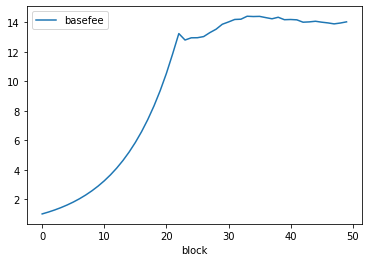

In [13]:
df.plot("block", ["basefee"])

<AxesSubplot:xlabel='block'>

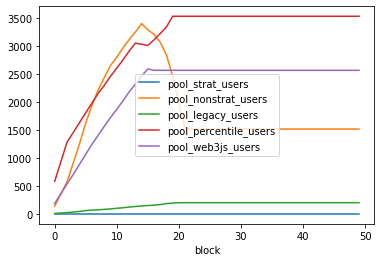

In [14]:
df.plot("block", ["pool_strat_users", "pool_nonstrat_users", "pool_legacy_users", "pool_percentile_users", "pool_web3js_users"])

<AxesSubplot:xlabel='block'>

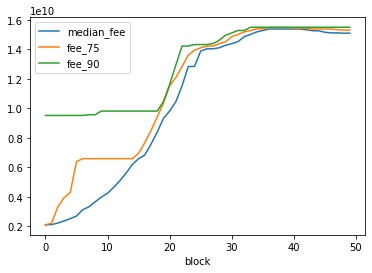

In [15]:
df.plot("block", ["median_fee", "fee_75", "fee_90"])

In [16]:
# Obtain the pool of users (all users spawned by the simulation)
user_pool_df = user_pool.export().rename(columns={ "pub_key": "sender" })

# Export the trace of the chain, all transactions included in blocks
chain_df = chain.export()

# Join the two to associate transactions with their senders
user_txs_df = chain_df.join(user_pool_df.set_index("sender"), on="sender")

<AxesSubplot:xlabel='block_height'>

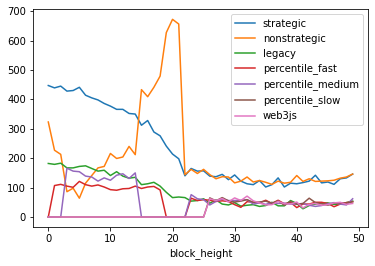

In [17]:
txs_per_user_type = user_txs_df.groupby(
    ["block_height", "user_type"]
).agg(
    { "user_type": len }
).unstack(level=-1).reset_index()

txs_per_user_type["user_type"] = txs_per_user_type["user_type"].fillna(0)
txs_per_user_type.columns = ["block_height", "strategic", "nonstrategic", "legacy", "percentile_fast", "percentile_medium", "percentile_slow", "web3js"]
txs_per_user_type.plot("block_height", ["strategic", "nonstrategic", "legacy", "percentile_fast", "percentile_medium", "percentile_slow", "web3js"])

In [18]:
txs_per_user_type

,block_height,strategic,nonstrategic,legacy,percentile_fast,percentile_medium,percentile_slow,web3js
0,0,447.0,323.0,182.0,0.0,0.0,0.0,0.0
1,1,439.0,227.0,179.0,107.0,0.0,0.0,0.0
2,2,445.0,213.0,183.0,111.0,0.0,0.0,0.0
3,3,428.0,86.0,167.0,105.0,166.0,0.0,0.0
4,4,430.0,98.0,167.0,101.0,156.0,0.0,0.0
5,5,441.0,64.0,172.0,121.0,154.0,0.0,0.0
6,6,414.0,115.0,174.0,110.0,139.0,0.0,0.0
7,7,405.0,141.0,165.0,105.0,136.0,0.0,0.0
8,8,398.0,167.0,156.0,109.0,122.0,0.0,0.0
9,9,386.0,172.0,159.0,102.0,133.0,0.0,0.0


Now we add a tax to transactions. The tax can be viewed as:

User bids `n` gwei, and pays for `n` gwei.
The transaction's gas price at block `m` is `f(n, m)` where `f(n, m) < n` and `f(n, m) < f(n, m + 1)`

Use linear / exponential / gauss decay? 

This means the tax function is monotonic, where legacy transactions that get taxed are less likely to get included due to their higher cost for the user and lower return for the block producer. The tax revenue can either be burnt or used for funding of public goods through mechanisms such as Quadratic Funding.

In [19]:
tax_start_block = 5
tax = lambda n, m: n * (tax_start_block / m)

# Add tax to selected txs that are legacy
class MixedTaxTxPool(MixedTxPool):
    def select_transactions(self, params):
        # Miner side
        basefee = params["basefee"]
        max_tx_in_block = int(constants["MAX_GAS_EIP1559"] / constants["SIMPLE_TRANSACTION_GAS"])

        valid_txs = [tx for tx in self.txs.values() if tx.is_valid({ "basefee": basefee })]
        rng.shuffle(valid_txs)

        sorted_valid_demand = sorted(
            valid_txs,
            key = lambda tx: -tx.tip({ "basefee": basefee })
        )
        selected_txs = sorted_valid_demand[0:max_tx_in_block]

        return selected_txs

In [20]:
def simulate(demand_scenario, shares_scenario):
    # Instantiate a couple of things
    txpool = MixedTxPool()
    chain = Chain()
    metrics = []
    user_pool = MixedUserPool()
    
    # `params` are the "environment" of the simulation
    params = {
        # we start with the historic basefee based on previous txs
        "basefee": constants["INITIAL_BASEFEE"],
        # "basefee": initial_historic_basefee,
        "current_block": None,
        "min_premium": 1 * (10 ** 9),
        "recent_blocks": [],
    }

    for t in range(len(demand_scenario)):
        # set current block wi
        params["current_block"] = t

        # We return some demand which on expectation yields 2000 new users per round
        users = spawn_poisson_heterogeneous_demand(t, demand_scenario[t], shares_scenario[t])

        # Add new users to the pool
        # We query each new user with the current basefee value
        # Users either return a transaction or None if they prefer to balk
        decided_txs = user_pool.decide_transactions(users, params)

        # New transactions are added to the transaction pool
        txpool.add_txs(decided_txs)

        # The best valid transactions are taken out of the pool for inclusion
        selected_txs = Mi.select_transactions(params)
        txpool.remove_txs([tx.tx_hash for tx in selected_txs])

        # We create a block with these transactions
        block = Block1559(txs = selected_txs, parent_hash = chain.current_head, height = t, basefee = params["basefee"])
        params["recent_blocks"].append(block)
        # Record the min premium in the block
        params["min_premium"] = block.min_premium()

        # The block is added to the chain
        chain.add_block(block)

        # A couple of metrics we will use to monitor the simulation
        # A couple of metrics we will use to monitor the simulation
        pool_strat_users = len(
                [tx for tx in txpool.txs.values() if type(user_pool.users[tx.sender]) == StrategicUser])
        pool_nonstrat_users = len(
                [tx for tx in txpool.txs.values() if type(user_pool.users[tx.sender]) == OptimisticUser])
        pool_legacy_users = len(
                [tx for tx in txpool.txs.values() if type(user_pool.users[tx.sender]) == LegacyUser])
        pool_web3js_users = len(
                [tx for tx in txpool.txs.values() if type(user_pool.users[tx.sender]) == LegacyWeb3jsUser])

        row_metrics = {
            "block": t,
            "basefee": params["basefee"] / (10 ** 9),
            "users": len(users),
            "strategic": len([user for user in users if type(user) is StrategicUser]),
            "nonstategic": len([user for user in users if type(user) is OptimisticUser]),
            "legacy": len([user for user in users if type(user) is LegacyUser]),
            "web3js": len([user for user in users if type(user) is LegacyWeb3jsUser]),
            "decided_txs": len(decided_txs),
            "included_txs": len(selected_txs),
            "blk_min_premium": block.min_premium() / (10 ** 9), # to Gwei
            "pool_length": txpool.pool_length,
            "pool_strat_users": pool_strat_users,
            "pool_nonstrat_users": pool_nonstrat_users,
            "pool_legacy_users": pool_legacy_users,
            "pool_web3js_users": pool_web3js_users,
        }
        metrics.append(row_metrics)

        # Finally, basefee is updated and a new round starts
        params["basefee"] = update_basefee(block, params["basefee"])

    return (pd.DataFrame(metrics), user_pool, chain)